## 0. Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, TFAlbertModel, TFElectraModel, TFDistilBertModel, DistilBertModel
from transformers import ElectraTokenizer, BertTokenizerFast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2022-07-09 18:13:24.721229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 18:13:24.732014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 18:13:24.732623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 18:13:24.759616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
strategy = tf.distribute.get_strategy()

## 1. Load Dataset

In [3]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')
train_multinli = pd.read_csv('../dataset/kornli/multinli.train.ko.tsv', delimiter='\t', error_bad_lines=False)
train_snli = pd.read_csv('../dataset/kornli/snli_1.0_train.ko.tsv', delimiter='\t')

/tmp/ipykernel_16359/2247244841.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_multinli = pd.read_csv('../dataset/kornli/multinli.train.ko.tsv', delimiter='\t', error_bad_lines=False)
b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


In [4]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [5]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [6]:
train_multinli.head()

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral


In [7]:
train_snli.head()

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [8]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")
print(f"train_multinli => {train_multinli.shape}")
print(f"train_snli => {train_snli.shape}")


train shape => (19996, 4) 
test shape => (5000, 3)
train_multinli => (385494, 3)
train_snli => (550152, 3)


In [9]:
train.drop(['index'], axis=1, inplace=True)

In [10]:
train_multinli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [11]:
train_snli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [12]:
train_target1 = train
train_target2 = train_multinli.sample(5000, random_state=42)
train_target3 = train_snli.sample(5000, random_state=42)

In [13]:
train_all = pd.concat([train_target1,train_target2,train_target3], ignore_index=True)

In [14]:
train_all = train_all.sample(frac=1).reset_index(drop=True)

In [15]:
train_all.head()

,premise,hypothesis,label
0,공개된 영상에 따르면 전동 킥보드를 타고 인도 위 자전거 도로를 지나가던 한 남성이...,이번 킥보드 사고로 여자 어린이가 크게 다쳤다.,neutral
1,"목란 부산점은 서울 연희동에 있는 목란 본점과 달리, 예약 없이도 갈 수 있다.",목란은 부산점과 서울 본점이 전부이다.,neutral
2,마룬 드레스를 입은 여자가 바닥에 누워 있는 마룬 셔츠를 입은 남자의 팔을 잡아당기...,한 무리의 유아들이 해변에서 놀고 있다.,contradiction
3,"음, 아무것도 생각나지 않아. 그래서 나는 그렇게 생각하지 않아.","오, 물론, 나는 분명히 기억한다",contradiction
4,그는 경찰수사를 받던중 지난해 12월 지인과 연락을 끊은 채 연고가 없는 광주광역시...,그는 사기혐의로 경찰 수사를 받고 있었다.,neutral


In [16]:
train_all.tail()

,premise,hypothesis,label
29991,빨간 재킷을 입은 어린 소녀를 위로하는 젊은 갈색 머리 남자.,젊은 갈색머리 남자가 빨간 재킷을 입은 어린 소녀를 모욕하고 있다.,contradiction
29992,청나라 말기 중국 광동성에서 보지림이라는 의원과 무관을 운영하고 있는 황기영은 자신...,황기영은 보지림이라는 의원을 운영한다.,entailment
29993,"다행스럽게 형은 면했지만, 계속되는 재판과 주위의 시선에 의해서 많은 것을 잃었다고...",계속되는 재판에 의해서 잃은 것이 많다.,entailment
29994,인근 숙소에서 모항 해수욕장의 전망을 한 눈에 볼 수 있어 아름다운 경관을 감상하며...,인근 숙소에서 모항 해수욕장의 아름다운 경관을 감상하며 왁자지껄하게 피서를 즐기기 좋다.,contradiction
29995,연방 CIO는 이 가이드를 위해 인터뷰한 CIO가 직면한 많은 요소를 포함하는 환경...,인터뷰한 CIO는 연방 CIO에 유용한 정보를 제공합니다.,entailment


In [17]:
train_all = train_all.astype({'label':'str'})

## 2. EDA

### 2.1. LabelEncoder을 통해 str형태의 label을 숫자로 변환

In [18]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train_all[e] = le.fit_transform(train_all[e])

In [19]:
train_all.head()

,premise,hypothesis,label
0,공개된 영상에 따르면 전동 킥보드를 타고 인도 위 자전거 도로를 지나가던 한 남성이...,이번 킥보드 사고로 여자 어린이가 크게 다쳤다.,2
1,"목란 부산점은 서울 연희동에 있는 목란 본점과 달리, 예약 없이도 갈 수 있다.",목란은 부산점과 서울 본점이 전부이다.,2
2,마룬 드레스를 입은 여자가 바닥에 누워 있는 마룬 셔츠를 입은 남자의 팔을 잡아당기...,한 무리의 유아들이 해변에서 놀고 있다.,0
3,"음, 아무것도 생각나지 않아. 그래서 나는 그렇게 생각하지 않아.","오, 물론, 나는 분명히 기억한다",0
4,그는 경찰수사를 받던중 지난해 12월 지인과 연락을 끊은 채 연고가 없는 광주광역시...,그는 사기혐의로 경찰 수사를 받고 있었다.,2


### 훈련 데이터의 결측치 확인

In [20]:
train_all.isnull().sum()

premise       0
hypothesis    3
label         0
dtype: int64

In [21]:
train_all.dropna(inplace=True)

In [22]:
train_all.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

In [23]:
len(train_all)

29993

### 클래스의 불균형이 있는지 시각화하여 확인

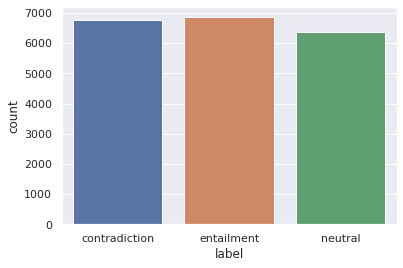

In [24]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

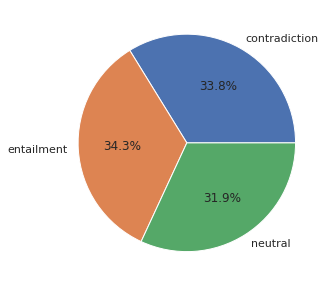

In [25]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3. Modeling

최종 목표인 Stacking Ensemble을 적용하기 위해서 개별 모델 3가지를 구현했습니다.  
각각 사전학습된 ELECTRA, BERT, ALBERT 모델에 대해 fine-tune을 적용했습니다.  
이전 electra 개별 모델 구현 파일에서 토크나이징 후 조정할 패딩의 길이를 100으로 정했습니다.  
따라서, 각각의 모델들의 input_layer의 shape을 (100,)으로 지정했습니다.  

### 3.1 모델별 토크나이저 선언

In [26]:
tokenizer_bert = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
tokenizer_albert = BertTokenizerFast.from_pretrained("kykim/albert-kor-base")
tokenizer_electra = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.


### 3.2 훈련 데이터 전처리

훈련데이터에 대해 각 문장에 대한 인코딩을 수행하고 패딩을 맞춰주는 전처리 작업을 진행합니다.  
토크나이징이 진행된 문장들에 대해 평균, 최대, 표준편차, 시각화를 통해 적절한 패딩 길이를 계산합니다.  
그 이후, 훈련데이터를 7:3 비율로 훈련데이터와 검증데이터를 나눕니다.  
검증데이터는 각 개별 모델로 예측을 진행하고, 클래스에 대한 예측 확률 값들과 예측 클래스 값들을 통해 앙상블 데이터로 사용하게 됩니다.  
따라서, 최종 제출할 대상이 되는 테스트 데이터에 대해서도 예측을 하고 예측 확률 값들과 클래스를 저장하는 같은 과정을 거치게 됩니다.  

#### 패딩 적절 길이 구하기

ELECTRA 모델과 BERT기반 두 가지의 모델로 패딩값을 정해야하기 때문에,  
각각의 토크나이저를 사용해 두 번 계산하여 패딩 길이를 구했습니다.  
첫 번째 ELECTRA 모델의 경우 평균 길이 40, 최대 길이 1680, 표준편차 17로 측정되었습니다.  
최종 예측해야할 테스트 파일의 경우 토큰의 최대 길이가 98이기 때문에 100의 길이가 적절하다고 판단했습니다.  
따라서, 100이상이 되는 훈련 데이터는 삭제했습니다.  
BERT 모델에 대해서도 똑같은 과정을 진행했습니다.  

In [27]:
train_data = train_all[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

#### ELECTRA

In [28]:
train_encoded_electra = tokenizer_electra.batch_encode_plus(train_data)
test_encoded_electra = tokenizer_electra.batch_encode_plus(test_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (1280 > 512). Running this sequence through the model will result in indexing errors


In [29]:
cal_length = train_encoded_electra['input_ids'] + test_encoded_electra['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 40.32646529305861
토큰 길이 최대: 2163
토큰 길이 표준편차: 20.27479359153581


In [30]:
test_num_tokens_electra = [len(tokens) for tokens in test_encoded_electra['input_ids']]
print(f"토큰 길이 최대: {np.max(test_num_tokens_electra)}")

토큰 길이 최대: 98


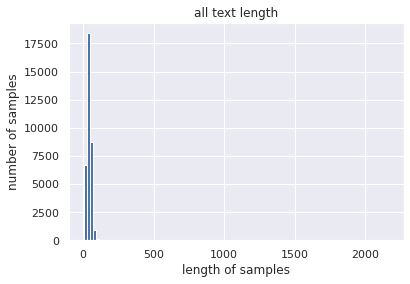

In [31]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
select_length = 100

In [33]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [34]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 0.996999399879976


#### 길이가 100 이상인 데이터에 대해 삭제 진행  

In [35]:
temp = []
for i in range(len(train_encoded_electra['input_ids'])):
    if len(train_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train_all.drop(train_all.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded_electra['input_ids'])):
    if len(test_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]
    test.drop(test.index[i], inplace=True)

#### BERT, ALBERT

In [36]:
train_encoded_bert = tokenizer_electra.batch_encode_plus(train_data)
test_encoded_bert = tokenizer_electra.batch_encode_plus(test_data)

In [37]:
cal_length = train_encoded_bert['input_ids'] + train_encoded_bert['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 39.880252944325484
토큰 길이 최대: 100
토큰 길이 표준편차: 14.53570378292455


In [38]:
test_num_tokens_bert = [len(tokens) for tokens in test_encoded_bert['input_ids']]
print(f"토큰 길이 최대: {np.max(test_num_tokens_bert)}")

토큰 길이 최대: 98


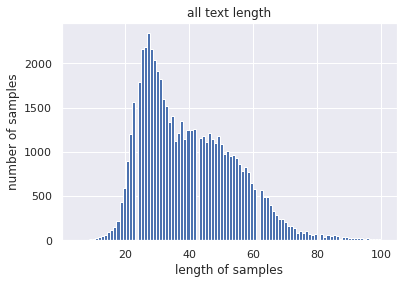

In [39]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 길이가 100 이상인 데이터에 대해 삭제 진행  

In [40]:
temp = []
for i in range(len(train_encoded_bert['input_ids'])):
    if len(train_encoded_bert['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train_all.drop(train_all.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded_bert['input_ids'])):
    if len(test_encoded_bert['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]
    test.drop(test.index[i], inplace=True)

In [41]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 1.0


In [42]:
len(train_data)

29888

In [43]:
len(test_data)

5000

#### 3.3.1 ELECTRA 모델링

In [44]:
train_encoded_electra = tokenizer_electra.batch_encode_plus(train_data, padding='max_length', max_length=np.max(num_tokens))
test_encoded_electra = tokenizer_electra.batch_encode_plus(test_data, padding='max_length', max_length=np.max(num_tokens))

In [45]:
cal_length = train_encoded_bert['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

In [46]:
train_encoded_electra = tokenizer_electra.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_electra = tokenizer_electra.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [47]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train_all.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_electra['input_ids']

In [48]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [49]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(np.max(num_tokens),), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [50]:
model_electra = model_KoELECTRA()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [51]:
history_electra = model_electra.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                     validation_data=valid_dataset,epochs= 3)

Epoch 1/3
999/999 [==============================] - 206s 197ms/step - loss: 0.7060 - accuracy: 0.6873 - val_loss: 0.5590 - val_accuracy: 0.7855
Epoch 2/3
999/999 [==============================] - 198s 198ms/step - loss: 0.4803 - accuracy: 0.8142 - val_loss: 0.5043 - val_accuracy: 0.8152
Epoch 3/3
999/999 [==============================] - 199s 199ms/step - loss: 0.3529 - accuracy: 0.8699 - val_loss: 0.5119 - val_accuracy: 0.8212


앙상블 데이터를 만들 electra_pred(클래스에 대한 확률 예측 값들의 배열), electra_pred_class(각 행의 최종 예측 클래스 값들의 배열)  
최종 예측을 하기 위한 test_pred_electra (주어진 5000개의 테스트 데이터에 대한 확률 예측 값들의 배열),  
test_pred_electra_class (주어진 5000개의 테스트 데이터에 대한 최종 예측 클래스 값들의 배열)

In [52]:
electra_pred = model_electra.predict(x_valid, verbose=1)
electra_pred_class = np.argmax(electra_pred, axis=1)

281/281 [==============================] - 26s 87ms/step


In [53]:
test_pred_electra = model_electra.predict(test_dataset, verbose=1)
test_pred_electra_class = np.argmax(test_pred_electra, axis=1)

250/250 [==============================] - 17s 62ms/step


#### 3.3.2 BERT, ALBERT 모델링

In [54]:
train_encoded_bert = tokenizer_bert.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_bert = tokenizer_bert.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [55]:
cal_length = train_encoded_bert['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

In [56]:
train_encoded_bert = tokenizer_bert.batch_encode_plus(train_data, padding='max_length', max_length= np.max(num_tokens))
test_encoded_bert = tokenizer_bert.batch_encode_plus(test_data, padding='max_length', max_length= np.max(num_tokens))

In [57]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_bert['input_ids'], train_all.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_bert['input_ids']

In [58]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [59]:
def model_BERT():
    with strategy.scope():
        encoder = TFBertModel.from_pretrained("kykim/bert-kor-base")

        input_layer = Input(shape=(np.max(num_tokens),), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_ALBERT():
    with strategy.scope():
        encoder = TFAlbertModel.from_pretrained("kykim/albert-kor-base")

        input_layer = Input(shape=(np.max(num_tokens),), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [60]:
model_bert = model_BERT()
model_albert = model_ALBERT()

2022-07-09 18:27:28.185959: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129024000 exceeds 10% of free system memory.
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
2022-07-09 18:27:32.628361: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21504000 exceeds 10% of free system memory.
All model checkpoint layers were used when initializing TFAlbertModel.

All the layers of TFAlbertModel were initialized from the model checkpoint at kykim/albert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [61]:
history_bert = model_bert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                              validation_data=valid_dataset, epochs= 3)

history_albert = model_albert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                  validation_data=valid_dataset, epochs= 3)

Epoch 1/3
999/999 [==============================] - 215s 205ms/step - loss: 0.8455 - accuracy: 0.6074 - val_loss: 0.5840 - val_accuracy: 0.7655
Epoch 2/3
999/999 [==============================] - 204s 204ms/step - loss: 0.5290 - accuracy: 0.7879 - val_loss: 0.5794 - val_accuracy: 0.7783
Epoch 3/3
999/999 [==============================] - 204s 204ms/step - loss: 0.3833 - accuracy: 0.8541 - val_loss: 0.6175 - val_accuracy: 0.7977
Epoch 1/3
999/999 [==============================] - 204s 196ms/step - loss: 0.8377 - accuracy: 0.6051 - val_loss: 0.6698 - val_accuracy: 0.7233
Epoch 2/3
999/999 [==============================] - 194s 194ms/step - loss: 0.5603 - accuracy: 0.7713 - val_loss: 0.6322 - val_accuracy: 0.7418
Epoch 3/3
999/999 [==============================] - 194s 194ms/step - loss: 0.3870 - accuracy: 0.8534 - val_loss: 0.7109 - val_accuracy: 0.7474


앙상블 데이터를 만들 bert_pred(클래스에 대한 확률 예측 값들의 배열), bert_pred_class(각 행의 최종 예측 클래스 값들의 배열)  
최종 예측을 하기 위한 test_pred_bert (주어진 5000개의 테스트 데이터에 대한 확률 예측 값들의 배열),  
test_pred_bert_class (주어진 5000개의 테스트 데이터에 대한 최종 예측 클래스 값들의 배열)  
albert 모델도 변수명만 bert에서 albert로 동일합니다.  

In [62]:
bert_pred = model_bert.predict(x_valid, verbose=1)
albert_pred = model_albert.predict(x_valid)

281/281 [==============================] - 27s 90ms/step


In [63]:
bert_pred_class = np.argmax(bert_pred, axis=1)
albert_pred_class = np.argmax(albert_pred, axis=1)

In [64]:
test_pred_bert = model_bert.predict(test_dataset, verbose=1)
test_pred_albert = model_albert.predict(test_dataset, verbose=1)

test_pred_bert_class = np.argmax(test_pred_bert, axis=1)
test_pred_albert_class = np.argmax(test_pred_albert, axis=1)

250/250 [==============================] - 18s 66ms/step


## 4. Stacking & Boosting Ensemble learning

이전에 구했었던 검증 데이터에 대해 개별 모델로 예측한 메타데이터를 생성하여 스태킹 앙상블에 대한 훈련 데이터를 만들었습니다.  
또한, 최종 예측할 테스트 데이터에 대한 개별 모델 예측 메타데이터도 생성했습니다.  
만들어진 메타 데이터 학습을 하며 Stacking 앙상블을, 최종 판별 모델을 XGBoost를 사용하며 Boosting 앙상블을 적용했습니다.  
이렇게 만들어진 XGBoost 모델을 통해 테스트 메타 데이터에 똑같이 적용함으로써 최종 예측을 진행했습니다.  

### 4.1 메타 데이터 생성

위에서 구한 electra_pred, electra_pred_class, bert_pred, bert_pred_class, albert_pred, albert_pred_class 변수에 선언된 배열 값들을  
활용해 최종 판별 모델 XGBoost에 적용할 앙상블 데이터셋을 만들었습니다.  

In [65]:
meta_data = np.array([
    np.transpose(electra_pred)[0], np.transpose(electra_pred)[1], np.transpose(electra_pred)[2], electra_pred_class,
    np.transpose(bert_pred)[0], np.transpose(bert_pred)[1], np.transpose(bert_pred)[2], bert_pred_class,
    np.transpose(albert_pred)[0], np.transpose(albert_pred)[1], np.transpose(albert_pred)[2], albert_pred_class
])
print(meta_data.shape)

(12, 8967)


In [66]:
meta_data = np.transpose(meta_data)
print(meta_data.shape)

(8967, 12)


### 4.2 XGBoost Modeling

In [67]:
from xgboost import XGBClassifier

xgb_final = XGBClassifier(silent=False,
                          n_estimators = 10000,
                          booster='gbtree',
                          tree_method='gpu_hist',
                          preidctor= 'gpu_predictor',
                          learning_rate=0.1,
                          objective='multi:softmax',
                          max_depth = 8,
                          subsample = 0.8,
                          random_state=42)

In [68]:
final_model = xgb_final.fit(meta_data, y_valid)

[18:49:58] WARNING: ../src/learner.cc:627: 
Parameters: { "preidctor", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [69]:
final = final_model.predict(meta_data)

In [70]:
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_valid , final)))

최종 메타 모델의 예측 정확도: 1.0000


In [71]:
len(final)

8967

### 4.3 최종 예측 메타 데이터 생성 및 최종 판별 진행

In [72]:
test_meta_data = np.array([
    np.transpose(test_pred_electra)[0], np.transpose(test_pred_electra)[1], np.transpose(test_pred_electra)[2], test_pred_electra_class,
    np.transpose(test_pred_bert)[0], np.transpose(test_pred_bert)[1], np.transpose(test_pred_bert)[2], test_pred_bert_class,
    np.transpose(test_pred_albert)[0], np.transpose(test_pred_albert)[1], np.transpose(test_pred_albert)[2], test_pred_albert_class
])
print(test_meta_data.shape)

(12, 5000)


In [73]:
test_meta_data = np.transpose(test_meta_data)

In [74]:
print(test_meta_data.shape)

(5000, 12)


In [75]:
predictions = final_model.predict(test_meta_data)

In [76]:
predictions

array([0, 1, 2, ..., 2, 0, 0], dtype=int32)

In [77]:
list1 = [i for i in range(5000)]

In [78]:
list2 = predictions

In [79]:
submission = pd.DataFrame({'index':list1,
                           'label':list2})

In [80]:
submission

,index,label
0,0,0
1,1,1
2,2,2
3,3,1
4,4,2
...,...,...
4995,4995,2
4996,4996,0
4997,4997,2
4998,4998,0


In [81]:
# contradiction => 0 entailment => 1 neutral => 2
submission['label'].replace(0, 'contradiction', inplace=True)
submission['label'].replace(1, 'entailment', inplace=True)
submission['label'].replace(2, 'neutral', inplace=True)

In [82]:
submission.to_csv("../submission/submission_stacking_v4.csv", index = False)

In [ ]:
# model.save('competition_stacking_v1.h5')
# Load model code
# new_model = tf.keras.models.load_model('competition_stacking_v1.h5')
# test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)